In [60]:
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

%matplotlib inline

In [61]:
# Load and inspect data
df = pd.read_csv('xAPI-Edu-Data.csv')
df.head(1)

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M


In [62]:
# Select relevant columns
CONTINUOUS_COLUMNS = ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']
DISCRETE_COLUMNS = ['StudentAbsenceDays']
FEATURE_COLUMNS = CONTINUOUS_COLUMNS + DISCRETE_COLUMNS
LABEL_COLUMN = 'Class'
df = df[FEATURE_COLUMNS + [LABEL_COLUMN]]

# Convert 

# Convert label to numerical value
label_str2int = {'L': 0, 'M': 1, 'H': 2}
label_int2str = ['L', 'M', 'H']
df[LABEL_COLUMN] = df[LABEL_COLUMN].apply(lambda x: label_str2int[x])
df.head(1)

,raisedhands,VisITedResources,AnnouncementsView,Discussion,StudentAbsenceDays,Class
0,15,16,2,20,Under-7,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cf9d390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11dac0cf8>]], dtype=object)

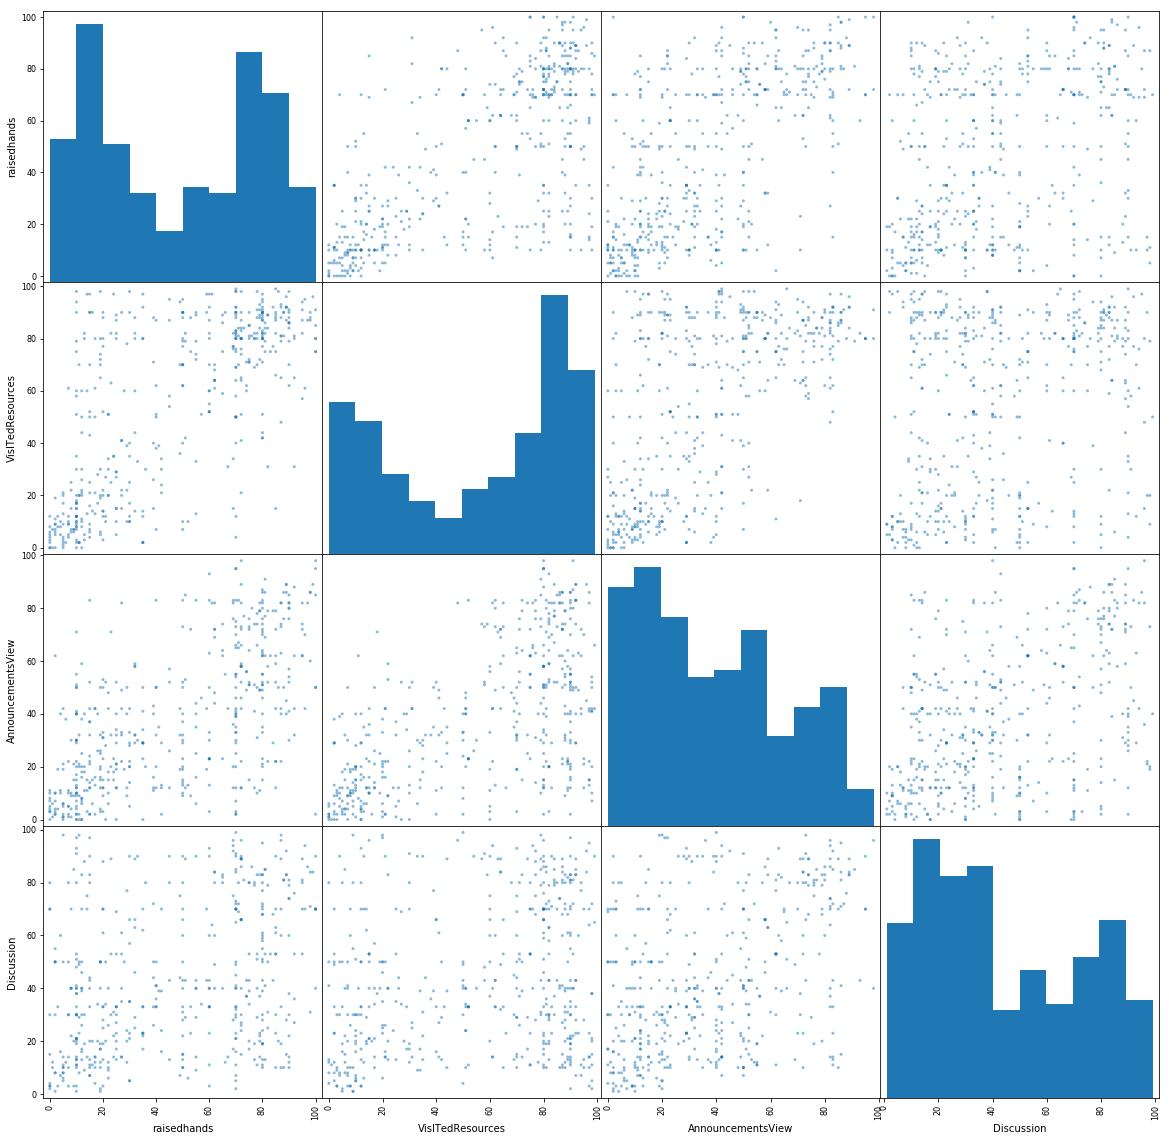

In [63]:
# Visualize relationships between features
pd.plotting.scatter_matrix(df[FEATURE_COLUMNS], figsize=(20, 20))

In [76]:
# Define tensorflow input functions
def create_tensor_cols(dataset_idxs):
    """ Create tensors for each of the columns """
    df_dataset = df.loc[dataset_idxs, :]
    cont_cols = {k: tf.constant(df_dataset[k].values) for k in CONTINUOUS_COLUMNS}
    discr_cols = {
        k: tf.SparseTensor(indices=[[i, 0] for i in range(df_dataset[k].size)],
                           values=df_dataset[k].values,
                           dense_shape=[df_dataset[k].size, 1])
        for k in DISCRETE_COLUMNS
    }
    feature_cols = {**cont_cols, **discr_cols}
    label = tf.constant(df_dataset[LABEL_COLUMN].values)
    return feature_cols, label

In [77]:
# Define tensorflow feature columns
# Sparse base columns
absent_c = tf.contrib.layers.sparse_column_with_keys(
    column_name='StudentAbsenceDays', keys=['Above-7', 'Under-7'])

# Continuous base columns
raise_hands_c = tf.contrib.layers.real_valued_column('raisedhands')
view_course_c = tf.contrib.layers.real_valued_column('VisITedResources')
view_announcements_c = tf.contrib.layers.real_valued_column('AnnouncementsView')
participate_discussion_c = tf.contrib.layers.real_valued_column('Discussion')

In [87]:
# Train & evaluate model with k-fold cross validation
k_fold = KFold(n_splits=10)
model_results = None
for train_idxs, eval_idxs in k_fold.split(np.arange(len(df))):
    if model_results is not None:
        continue
    def train_input_fn():
        return create_tensor_cols(train_idxs)
    def eval_input_fn():
        return create_tensor_cols(eval_idxs)
    model_dir = tempfile.mkdtemp()
    # TODO: Try other models
    model = tf.contrib.learn.LinearClassifier(
        feature_columns=[absent_c, raise_hands_c, view_course_c, view_announcements_c, participate_discussion_c],
        model_dir=model_dir,
        optimizer=tf.train.FtrlOptimizer(
            learning_rate=0.1,
            l1_regularization_strength=1.0,
            l2_regularization_strength=1.0))
    model.fit(input_fn=train_input_fn, steps=200)
    model_results = model.evaluate(input_fn=eval_input_fn, steps=1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1305ca240>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving

In [88]:
# Print model eval results
for key in sorted(gg):
    print("%s: %s" % (key, gg[key]))

accuracy: 0.479167
accuracy/baseline_label_mean: 0.6875
accuracy/threshold_0.500000_mean: 0.479167
auc: 0.5
global_step: 200
labels/actual_label_mean: 0.6875
labels/prediction_mean: 1.0
loss: 11.451
precision/positive_threshold_0.500000_mean: 0.583333
recall/positive_threshold_0.500000_mean: 1.0


In [92]:
# Try a prediction
pred_features, pred_label = create_tensor_cols(np.random.randint(0, len(df), size=1))
pred_class = model.predict(pred_features)  # This fails right now, seems like a tf issue
print('Predicted: %s\nActual: %s' % (pred_class, pred_label))

Instructions for updating:
Please switch to predict_classes, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


AttributeError: 'SparseTensor' object has no attribute 'shape'